#WEB SERVER LOG ANALYSIS WITH APACHE SPARK

##1.Apache Web Server Log File

The log files are in format [Apache Common Log Format(CFL)](http://httpd.apache.org/docs/1.3/logs.html#common).<br />
It looks like something:<br />
127.0.0.1 - - [01/Aug/1995:00:00:01 -0400] "GET /images/launch-logo.gif HTTP/1.0" 200 1839

**Each part is described below**

- **127.0.0.1** ####This is the IP address (or host name, if available) of the client (remote host) which made the request to the server.

-   **`"-"`**   ####The "hyphen" in the output indicates that the requested piece of information (user identity from remote machine) is not available.

- **[01/Aug/1995:00:00:01 -0400]** ####The time that the server finished processing the request. The format is  : [day/month/year:hour:minute:second timezone]
 
      ####day = 2 digits
      ####month = 3 letters
      ####year = 4 digits
      ####hour = 2 digits
      ####minute = 2 digits
      ####second = 2 digits
      ####zone = (+ | -) 4 digits
- **"GET /images/launch-logo.gif HTTP/1.0"** ####This is the first line of the request string from the client. It consists of a three components: the request method (e.g., GET, POST, etc.), the endpoint (a Uniform Resource Identifier), and the client protocol version.

- **200** ####This is the status code that the server sends back to the client. This information is very valuable, because it reveals whether the request resulted in a successful response (codes beginning in 2), a redirection (codes beginning in 3), an error caused by the client (codes beginning in 4), or an error in the server (codes beginning in 5). The full list of possible status codes can be found in the HTTP specification (RFC 2616 section 10).

- **1839** ####The last entry indicates the size of the object returned to the client, not including the response headers. If no content was returned to the client, this value will be "-" (or sometimes 0).

###NASA-HTTP WEB SERVER LOG

We will use data set from NASA Kennedy Space Center WWW server in Florida.<br />
The full data set is freely available: <br />
(http://ita.ee.lbl.gov/html/contrib/NASA-HTTP.html)

###Parsing Log FILE:

In [1]:
#first build regular expression pattern to extract fields from log line
apache_log_pattern='^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)" (\d{3}) (\S+)'

In [2]:
#Create regular expression pattern to extract the nine fields
import re
import datetime

from pyspark.sql import Row

month_map = {'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
    'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12}

def parse_apache_time(s):
    '''S (str): data and time in Apache Log format'''
    return datetime.datetime(int(s[7:11]),month_map[s[3:6]],int(s[0:2]),
                            int(s[12:14]),int(s[15:17]),int(s[18:20]))

def parse_apache_logline(logline):
    '''logline (str): text line in Apache Log format'''
    match=re.search(apache_log_pattern,logline)
    if match is None:
        return (logline, 0)
    size_field = match.group(9)
    if size_field == '-':
        size = long(0)
    else:
        size = long(match.group(9))
    return (Row(
        host          = match.group(1),
        client_identd = match.group(2),
        user_id       = match.group(3),
        date_time     = parse_apache_time(match.group(4)),
        method        = match.group(5),
        endpoint      = match.group(6),
        protocol      = match.group(7),
        response_code = int(match.group(8)),
        content_size  = size
    ), 1)
    

###Creation of RDD

In [3]:
#path
logFile="../data/cs100/lab2/apache.access.log.PROJECT"

#read and parse Log Files
def parseLogs():
    
    parsed_logs=sc.textFile(logFile).map(parse_apache_logline).cache()
    
    access_logs=parsed_logs.filter(lambda s:s[1]==1).map(lambda s:s[0]).cache()
    
    failed_logs=parsed_logs.filter(lambda s:s[1]==0).map(lambda s:s[0])
    
    failed_logs_count=failed_logs.count()
    
    if failed_logs_count > 0:
        print 'Number of invalid logline: %d' % failed_logs.count()
        for line in failed_logs.take(20):
            print 'Invalid logline: %s' % line

    print 'Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (parsed_logs.count(), access_logs.count(), failed_logs.count())
    
    return parsed_logs, access_logs, failed_logs
    
    

parsed_logs, access_logs, failed_logs = parseLogs()
    

Number of invalid logline: 108
Invalid logline: ix-sac6-20.ix.netcom.com - - [08/Aug/1995:14:43:39 -0400] "GET / HTTP/1.0 " 200 7131
Invalid logline: ix-sac6-20.ix.netcom.com - - [08/Aug/1995:14:43:57 -0400] "GET /images/ksclogo-medium.gif HTTP/1.0 " 200 5866
Invalid logline: ix-sac6-20.ix.netcom.com - - [08/Aug/1995:14:44:07 -0400] "GET /images/NASA-logosmall.gif HTTP/1.0 " 200 786
Invalid logline: ix-sac6-20.ix.netcom.com - - [08/Aug/1995:14:44:11 -0400] "GET /images/MOSAIC-logosmall.gif HTTP/1.0 " 200 363
Invalid logline: ix-sac6-20.ix.netcom.com - - [08/Aug/1995:14:44:13 -0400] "GET /images/USA-logosmall.gif HTTP/1.0 " 200 234
Invalid logline: ix-sac6-20.ix.netcom.com - - [08/Aug/1995:14:44:15 -0400] "GET /images/WORLD-logosmall.gif HTTP/1.0 " 200 669
Invalid logline: ix-sac6-20.ix.netcom.com - - [08/Aug/1995:14:44:31 -0400] "GET /shuttle/countdown/ HTTP/1.0 " 200 4673
Invalid logline: ix-sac6-20.ix.netcom.com - - [08/Aug/1995:14:44:41 -0400] "GET /shuttle/missions/sts-69/count69.g

**Oh ou!!! So many failed parsed logs
<br />Try to alter `apache_log_pattern`**

U see there's space after `".../1.0 "` in every failed log file

In [4]:
apache_log_pattern='^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)\s*" (\d{3}) (\S+)'

In [5]:
#check out again
parsed_logs, access_logs, failed_logs = parseLogs()

Read 1043177 lines, successfully parsed 1043177 lines, failed to parse 0 lines


**Ohlala.....  failed : 0 logs **

####Let's Now do some Analysis

**Content size : average,minimum,maximum content size**

In [6]:
#create rdd of content size
content_sizes=access_logs.map(lambda log:log.content_size).cache()

#print min,max and avg content sizes
print content_sizes.min()

print content_sizes.max()

print content_sizes.sum()/content_sizes.count()


0
3421948
17531


**Response code Analysis**

In [7]:
#create rdd of responsecode and make tuple(responsecode,1) and reduce it by key to get count of unique response code
from operator import add
responsecode_count=access_logs.map(lambda log:(log.response_code,1)).reduceByKey(add).cache()

#print len
print responsecode_count.count()

#get top response code
print sorted(responsecode_count.take(100))


7
[(200, 940847), (302, 16244), (304, 79824), (403, 58), (404, 6185), (500, 2), (501, 17)]


**Response code visualize**

- Let's visualize the response_code using matplotlib.
- Extract the labels from responsecode_count, and normalize the features.

In [8]:
#extract labels
labels=responsecode_count.map(lambda (x,y):x).collect()
print labels

#normalize the feature
count=access_logs.count()
fracs=responsecode_count.map(lambda (x,y):(float(y)/count)).collect()
print fracs

[200, 304, 404, 500, 501, 302, 403]
[0.9019054292799784, 0.07652009198822443, 0.005929003419362198, 1.9172201841106543e-06, 1.629637156494056e-05, 0.015571662335346735, 5.5599385339208974e-05]


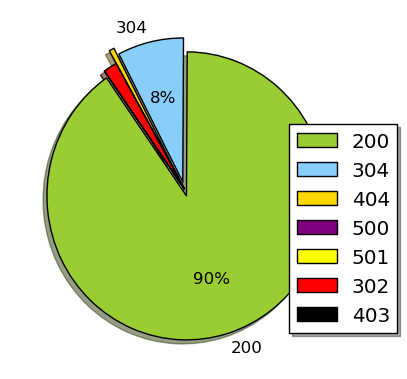

In [9]:
import matplotlib.pyplot as plt

def pie_format(value):
    return '' if value < 7 else '%.0f%%' % value

fig=plt.figure(figsize=(4.5,4.5),facecolor='white',edgecolor='white')

colors = ['yellowgreen', 'lightskyblue', 'gold', 'purple', 'yellow', 'red', 'black']

explode = (0.05, 0.05, 0.1, 0, 0, 0, 0)

patches, texts, autotexts = plt.pie(fracs, labels=labels, colors=colors,
                                    explode=explode, autopct=pie_format,
                                    shadow=True,  startangle=125)

for text, autotext in zip(texts, autotexts):
    if autotext.get_text() == '':
        text.set_text('')
        
plt.legend(labels, loc=(0.80, 0.1), shadow=True)


**Frequent Hosts Analysis**

Same as above get the tuple reduce by label and the filter out hosts who accessed the server more than 10 times

In [10]:
from operator import add
#create host tuple rdd
host_count=access_logs.map(lambda log:(log.host,1))

#count the frequency
hostSum=host_count.reduceByKey(add)

#filter out more than 10
host_10=hostSum.filter(lambda host:host[1]>10)

#pick top 20
host20=host_10.map(lambda host:host[0]).take(20)
host20

[u'slip3.nilenet.com',
 u'client-71-31.online.apple.com',
 u'ix-jac2-16.ix.netcom.com',
 u'slip124.qlink.queensu.ca',
 u'ppp0e-01.rns.tamu.edu',
 u'ix-ftl2-16.ix.netcom.com',
 u'202.40.17.51',
 u'dialin14.wantree.com.au',
 u'y1a.kootenay.net',
 u'199.242.22.79',
 u'133.65.48.113',
 u'weird.stardust.com',
 u'ucsdtv2.ucsd.edu',
 u'dialup2.speed.net',
 u'147.150.5.96',
 u'pc-117.grassroots.ns.ca',
 u'152.52.29.20',
 u'asyn01.lw2.noord.bart.nl',
 u'bilbo.klautern.fh-rpl.de',
 u'cywilli.psdn177.pacbell.com']

**Visualizing Endpoints**

Lets visualize the hits to endpoints(URls) 

In [19]:
endpoints=access_logs.map(lambda log:(log.endpoint,1)).reduceByKey(add).cache()

#get the labels and count
ends=endpoints.map(lambda (x,y):x).collect()
counts=endpoints.map(lambda (x,y):y).collect()



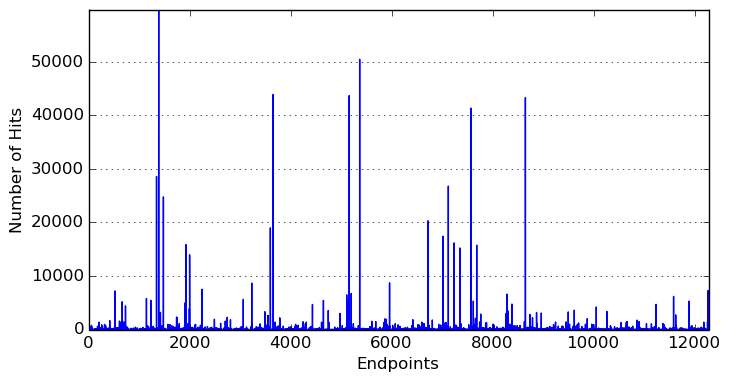

In [23]:
fig=plt.figure(figsize=(8,4),facecolor='white',edgecolor='white')

plt.axis([0,len(ends),0,max(counts)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Endpoints')
plt.ylabel('Number of Hits')
plt.plot(counts)

In [24]:
#get top 10 endpoints
endpoints.takeOrdered(10,lambda s:-1*s[1])

[(u'/images/NASA-logosmall.gif', 59737),
 (u'/images/KSC-logosmall.gif', 50452),
 (u'/images/MOSAIC-logosmall.gif', 43890),
 (u'/images/USA-logosmall.gif', 43664),
 (u'/images/WORLD-logosmall.gif', 43277),
 (u'/images/ksclogo-medium.gif', 41336),
 (u'/ksc.html', 28582),
 (u'/history/apollo/images/apollo-logo1.gif', 26778),
 (u'/images/launch-logo.gif', 24755),
 (u'/', 20292)]

**Top 10 Error endpoints**

We need top 10 error endpoints which does not return code 200

In [26]:
not200=access_logs.filter(lambda log:log.response_code!=200)

#get the label count
not200_count=not200.map(lambda x:(x.endpoint,1)).reduceByKey(add)

#get top 10
top10_not200=not200_count.takeOrdered(10,lambda s:-1*s[1])

print top10_not200

[(u'/images/NASA-logosmall.gif', 8761), (u'/images/KSC-logosmall.gif', 7236), (u'/images/MOSAIC-logosmall.gif', 5197), (u'/images/USA-logosmall.gif', 5157), (u'/images/WORLD-logosmall.gif', 5020), (u'/images/ksclogo-medium.gif', 4728), (u'/history/apollo/images/apollo-logo1.gif', 2907), (u'/images/launch-logo.gif', 2811), (u'/', 2199), (u'/images/ksclogosmall.gif', 1622)]


**Number of Unique Hosts**

In [28]:
uniqueHosts=access_logs.map(lambda log:log.host).distinct()

print uniqueHosts.count()

54507


**Number of unique daily hosts**

In [33]:
day_host_tuple=access_logs.map(lambda log:(log.date_time.day,log.host)).distinct().groupByKey()

dayhost_count=day_host_tuple.map(lambda x:(x[0],len(x[1]))).sortByKey().cache()

dailyHost_list=dayhost_count.take(30)

print dailyHost_list

[(1, 2582), (3, 3222), (4, 4190), (5, 2502), (6, 2537), (7, 4106), (8, 4406), (9, 4317), (10, 4523), (11, 4346), (12, 2864), (13, 2650), (14, 4454), (15, 4214), (16, 4340), (17, 4385), (18, 4168), (19, 2550), (20, 2560), (21, 4134), (22, 4456)]


**Visualizing unique daily hosts**

In [35]:
days_host=dayhost_count.map(lambda (x,y):x).collect()
hosts=dayhost_count.map(lambda (x,y):y).collect()

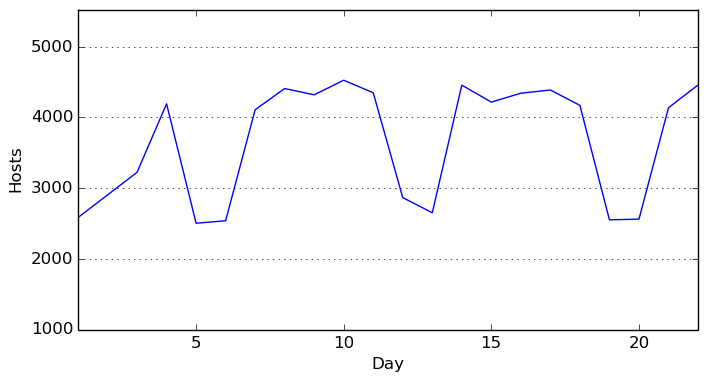

In [41]:
#plot the figure
fig=plt.figure(figsize=(8,4),facecolor='white',edgecolor='white')
plt.axis([min(days_host),max(days_host),1000,max(hosts)+1000])
plt.grid(b=True,which='major',axis='y')
plt.xlabel("Day")
plt.ylabel("Hosts")
plt.plot(days_host,hosts)


###Exploring 404 Response codes

**Count 404 codes in log**

In [42]:
badRecords=access_logs.filter(lambda log:log.response_code==404).cache()

#count number of badRecords
print badRecords.count()

6185


**Get Unique badRecords**

In [44]:
badEndpoints=badRecords.map(lambda x:x.endpoint).distinct()

#get 20 bad endpoints
badEndpoints.take(20)


[u'/11/history/apollo/images/',
 u'/128.159.104.89/tv/tv.html',
 u'/imag',
 u'/shuttle/missionssts-70/woodpecker.html',
 u'/~terrig/bookmark.html',
 u'/elv/ATLAS_CENTAUR/p-ae.gif',
 u'/pub.win',
 u'/ksc.nasa.gov/images/ksclogo-medium.gif',
 u'/history/apollo-13',
 u'/shuttle/missioins/sts-70/movies/',
 u'/shuttle/missions/sts-69/mission-sts-74.html',
 u'/shuttle/missions/sts-80/mission-sts-80.html',
 u'/histort/apollo/apollo13',
 u'/www/ksc',
 u'/shuttle/miccions/sts-73/mission-sts-73.html',
 u'/images/lf.gif',
 u'/shuttle/Missions/missions.html',
 u'/ksc',
 u'/shuttle/missions/mission.html/',
 u'/images/jpeg/']

**Listing top 20**

In [45]:
badEndpoints_tuple=badRecords.map(lambda x:(x.endpoint,1)).reduceByKey(add)

#get top 20
badEndpoints_top20=badEndpoints_tuple.takeOrdered(20,lambda x:-1*x[1])

badEndpoints_top20

[(u'/pub/winvn/readme.txt', 633),
 (u'/pub/winvn/release.txt', 494),
 (u'/shuttle/missions/STS-69/mission-STS-69.html', 431),
 (u'/images/nasa-logo.gif', 319),
 (u'/elv/DELTA/uncons.htm', 178),
 (u'/shuttle/missions/sts-68/ksc-upclose.gif', 156),
 (u'/history/apollo/sa-1/sa-1-patch-small.gif', 146),
 (u'/images/crawlerway-logo.gif', 120),
 (u'/://spacelink.msfc.nasa.gov', 117),
 (u'/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif', 100),
 (u'/history/apollo/a-001/a-001-patch-small.gif', 97),
 (u'/images/Nasa-logo.gif', 85),
 (u'/shuttle/resources/orbiters/atlantis.gif', 64),
 (u'/history/apollo/images/little-joe.jpg', 62),
 (u'/images/lf-logo.gif', 59),
 (u'/shuttle/resources/orbiters/discovery.gif', 56),
 (u'/shuttle/resources/orbiters/challenger.gif', 54),
 (u'/robots.txt', 53),
 (u'/elv/new01.gif>', 43),
 (u'/history/apollo/pad-abort-test-2/pad-abort-test-2-patch-small.gif', 38)]

**Listing 404 Response codes per day**

In [47]:
#badRecords day tuple
day_tuple=badRecords.map(lambda x:(x.date_time.day,1)).reduceByKey(add).sortByKey().cache()

#error by day
error_day=day_tuple.collect()
error_day

[(1, 243),
 (3, 303),
 (4, 346),
 (5, 234),
 (6, 372),
 (7, 532),
 (8, 381),
 (9, 279),
 (10, 314),
 (11, 263),
 (12, 195),
 (13, 216),
 (14, 287),
 (15, 326),
 (16, 258),
 (17, 269),
 (18, 255),
 (19, 207),
 (20, 312),
 (21, 305),
 (22, 288)]

**Visualize 404 code per day**

In [48]:
dayWithError404=day_tuple.map(lambda (x,y):x).collect()
count404=day_tuple.map(lambda (x,y):y).collect()

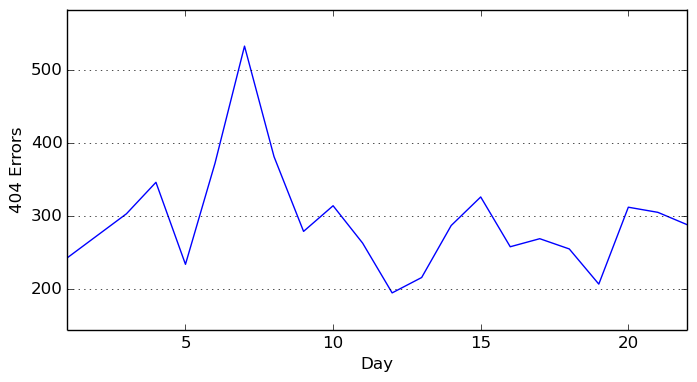

In [49]:
fig=plt.figure(figsize=(8,4),facecolor='white',edgecolor='white')
plt.axis([min(dayWithError404),max(dayWithError404),min(count404)-50,max(count404)+50])
plt.grid(b=True,which='major',axis='y')
plt.xlabel('Day')
plt.ylabel('404 Errors')
plt.plot(dayWithError404,count404)

**Listing 404 Errors by hour**

In [50]:
#badRecords hour tuple
hour_tuple=badRecords.map(lambda x:(x.date_time.hour,1)).reduceByKey(add).sortByKey().cache()

#error by day
error_hour=hour_tuple.collect()
error_hour

[(0, 175),
 (1, 171),
 (2, 422),
 (3, 272),
 (4, 102),
 (5, 95),
 (6, 93),
 (7, 122),
 (8, 199),
 (9, 185),
 (10, 329),
 (11, 263),
 (12, 438),
 (13, 397),
 (14, 318),
 (15, 347),
 (16, 373),
 (17, 330),
 (18, 268),
 (19, 269),
 (20, 270),
 (21, 241),
 (22, 234),
 (23, 272)]

**Visualize 404 Errors by Hour**

In [51]:
hourWithError404=hour_tuple.map(lambda (x,y):x).collect()
count404hour=hour_tuple.map(lambda (x,y):y).collect()

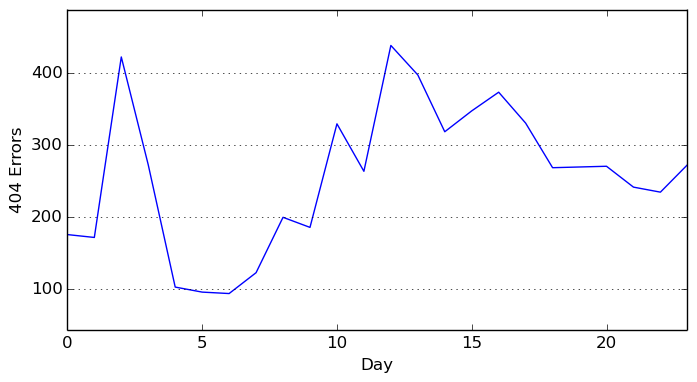

In [52]:
fig=plt.figure(figsize=(8,4),facecolor='white',edgecolor='white')
plt.axis([min(hourWithError404),max(hourWithError404),min(count404hour)-50,max(count404hour)+50])
plt.grid(b=True,which='major',axis='y')
plt.xlabel('Day')
plt.ylabel('404 Errors')
plt.plot(hourWithError404,count404hour)

#That's It  :)